# Consensus analysis of Reddit AITA dataset for each AITA class

\begin{equation*}
Cns(X) = 1 + \sum_{i=1}^n p_i\times \text{log}_2(1 - \frac{|X_i-\mu_x|}{d_x})
\end{equation*}

- Tastle, W. J., & Wierman, M. J. (2007). Consensus and dissention: A measure of ordinal dispersion. *International Journal of Approximate Reasoning, 45*(3), 531–545. doi:10.1016/j.ijar.2006.06.024

In [ ]:
%pip install datasets huggingface_hub tqdm

In [ ]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CPSS_24_Paper/results

import os
os.makedirs('consensus_analysis', exist_ok=True)

%cd /content/drive/MyDrive/CPSS_24_Paper/results/consensus_analysis

/content/drive/MyDrive/CPSS_24_Paper/results
/content/drive/MyDrive/CPSS_24_Paper/results/consensus_analysis


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from datasets import load_dataset, concatenate_datasets

# download HF dataset and drop unwanted columns (only need the AITA classes of the top 10 comments)

dataset = load_dataset("MattBoraske/Reddit-AITA-2018-to-2022")
dataset = concatenate_datasets([dataset['train'], dataset['test']])

In [ ]:
# create dataframe from HF dataset and map AITA classifications to their integer codings

df = dataset.to_pandas()

# mapping of classes to ordinal values
AITA_class_coding_map = {
    "NAH": 1,
    "NTA": 2,
    "YTA": 3,
    "ESH": 4,
}

# Columns to replace values in
columns_to_replace = ['top_comment_1_AITA_class_by_keyword','top_comment_2_AITA_class_by_keyword','top_comment_3_AITA_class_by_keyword','top_comment_4_AITA_class_by_keyword','top_comment_5_AITA_class_by_keyword','top_comment_6_AITA_class_by_keyword','top_comment_7_AITA_class_by_keyword','top_comment_8_AITA_class_by_keyword','top_comment_9_AITA_class_by_keyword','top_comment_10_AITA_class_by_keyword']

# Replace values in specific columns
df[columns_to_replace] = df[columns_to_replace].replace(AITA_class_coding_map)

In [ ]:
def calculate_consensus(row):
    # filter the row so that it only has these columns: 'top_comment_1_AITA_class_by_keyword', 'top_comment_2_AITA_class_by_keyword', and so on
    AITA_class_columns = [col for col in row.index if col.endswith('keyword')]
    row = row[AITA_class_columns].astype(int)

    # get the proportion of each AITA class (p_i)
    myFreq = row.value_counts()
    myPs = myFreq / sum(myFreq)

    # get the mean (average) of the integer encodings (mu_x)
    muX = row.mean()

    # get the range of all possible scores (d_x)
    dX = max(AITA_class_coding_map.values()) - min(AITA_class_coding_map.values())

    # calculate consensus
    myCat = np.array(myFreq.index)
    consensus_values = 1 - np.abs(myCat - muX) / dX
    consensus_values = np.clip(consensus_values, a_min=1e-10, a_max=None)  # Avoid log2 of 0 or negative values
    consensus = 1 + np.sum(myPs * np.log2(consensus_values))

    return consensus


df['consensus'] = df.apply(calculate_consensus, axis=1)

In [ ]:
# filter df to only contain samples where top_comment_1_AITA_class_by_keyword is NTA

df_NAH = df[df['top_comment_1_AITA_class_by_keyword'] == 1]
df_NTA = df[df['top_comment_1_AITA_class_by_keyword'] == 2]
df_YTA = df[df['top_comment_1_AITA_class_by_keyword'] == 3]
df_ESH = df[df['top_comment_1_AITA_class_by_keyword'] == 4]

In [ ]:
# save consensus stats to output JSON

import json

consensus_stats = {
    "All Classes": df['consensus'].describe().to_dict(),
    "NTA": df_NTA['consensus'].describe().to_dict(),
    "YTA": df_YTA['consensus'].describe().to_dict(),
    "NAH": df_NAH['consensus'].describe().to_dict(),
    "ESH": df_ESH['consensus'].describe().to_dict(),
}

with open('consensus_stats_by_AITA_class.json', 'w') as f:
    json.dump(consensus_stats, f)

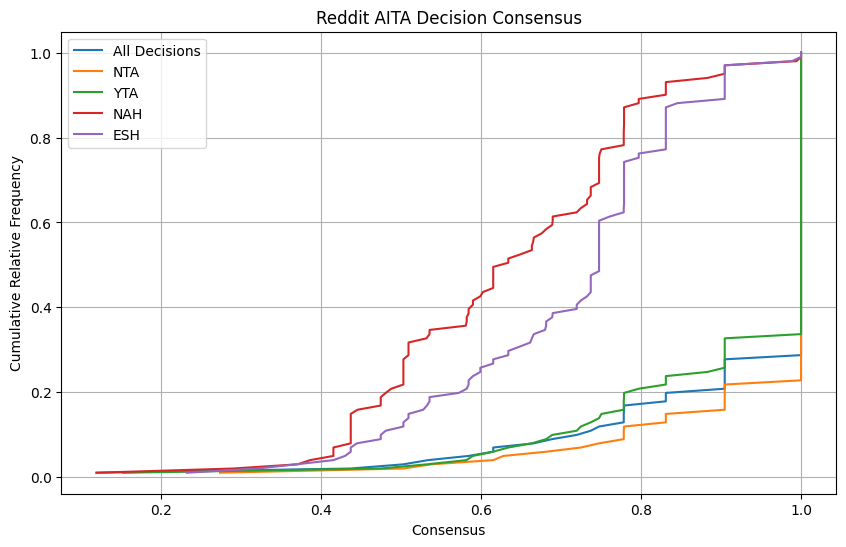

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# All classes
consensus_stats = np.percentile(df['consensus'], np.arange(0, 101, 1))
values = list(consensus_stats)
sorted_values = np.sort(values)
cumulative_frequency = np.arange(1, len(values) + 1) / len(values)
plt.plot(sorted_values, cumulative_frequency, label='All Decisions')

# NTA
consensus_stats = np.percentile(df_NTA['consensus'], np.arange(0, 101, 1))
values = list(consensus_stats)
sorted_values = np.sort(values)
cumulative_frequency = np.arange(1, len(values) + 1) / len(values)
plt.plot(sorted_values, cumulative_frequency, label='NTA')

# YTA
consensus_stats = np.percentile(df_YTA['consensus'], np.arange(0, 101, 1))
values = list(consensus_stats)
sorted_values = np.sort(values)
cumulative_frequency = np.arange(1, len(values) + 1) / len(values)
plt.plot(sorted_values, cumulative_frequency, label='YTA')

# NAH
consensus_stats = np.percentile(df_ESH['consensus'], np.arange(0, 101, 1))
values = list(consensus_stats)
sorted_values = np.sort(values)
cumulative_frequency = np.arange(1, len(values) + 1) / len(values)
plt.plot(sorted_values, cumulative_frequency, label='NAH')

# ESH
consensus_stats = np.percentile(df_NAH['consensus'], np.arange(0, 101, 1))
values = list(consensus_stats)
sorted_values = np.sort(values)
cumulative_frequency = np.arange(1, len(values) + 1) / len(values)
plt.plot(sorted_values, cumulative_frequency, label='ESH')

# plotting details
plt.title('Reddit AITA Decision Consensus')
plt.xlabel('Consensus')
plt.ylabel('Cumulative Relative Frequency')
plt.legend(loc='upper left')
plt.grid(True)

# save plot to output png and display
plt.savefig('consensus_by_AITA_class.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from datasets import Dataset

# push dataset with consensus column to HF hub

dataset = Dataset.from_pandas(df)
dataset.push_to_hub("MattBoraske/Reddit-AITA-2018-to-2022-with-consensus")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/MattBoraske/Reddit-AITA-2018-to-2022-with-consensus/commit/2aa15734b775f4fd8ee1af560f6a182bd77e68fa', commit_message='Upload dataset', commit_description='', oid='2aa15734b775f4fd8ee1af560f6a182bd77e68fa', pr_url=None, pr_revision=None, pr_num=None)